In [39]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW  # Import from torch.optim
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
    get_cosine_schedule_with_warmup
)
from sklearn.model_selection import train_test_split
import nltk
from nltk.translate.bleu_score import sentence_bleu
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [40]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [41]:
# Load and explore the dataset
df = pd.read_csv('/kaggle/input/football/final_commentary_dataset.csv')

# Display basic info
print(f"Dataset size: {len(df)}")
print("\nFirst few rows:")
df.head()

Dataset size: 1272

First few rows:


,Commentary,MatchReport
0,First Half begins. Foul by Dominic Calvert-Lew...,The first half saw a lot of back-and-forth pla...
1,"Corner, Arsenal. Conceded by Jarrad Branthwait...",Arsenal dominated possession with numerous att...
2,Fourth official has announced 1 minutes of add...,The match remains goalless. Arsenal had severa...
3,"Offside, Arsenal. Bukayo Saka is caught offsid...",The first half concluded scoreless. Arsenal ha...
4,"First Half begins. Offside, Liverpool. Cody Ga...",The first half saw Liverpool's Cody Gakpo scor...


Commentary length statistics:
count    1272.000000
mean      279.221698
std        86.029076
min        62.000000
25%       215.000000
50%       274.500000
75%       336.000000
max       500.000000
Name: Commentary_Length, dtype: float64

MatchReport length statistics:
count    1272.000000
mean       48.704403
std         7.395474
min        25.000000
25%        44.000000
50%        49.000000
75%        53.000000
max        73.000000
Name: MatchReport_Length, dtype: float64


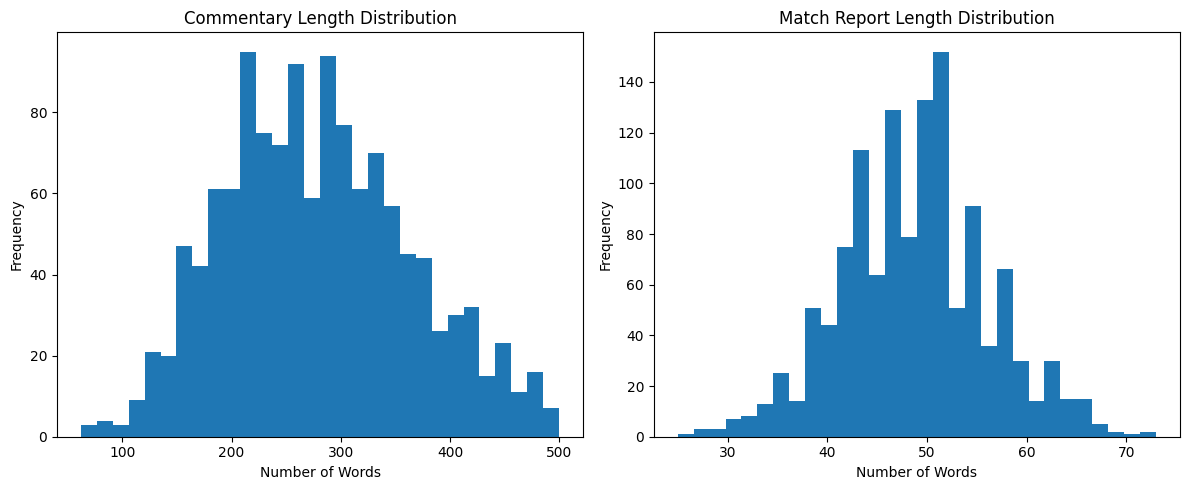

In [42]:
# Let's see length distributions
df['Commentary_Length'] = df['Commentary'].apply(lambda x: len(x.split()))
df['MatchReport_Length'] = df['MatchReport'].apply(lambda x: len(x.split()))

print("Commentary length statistics:")
print(df['Commentary_Length'].describe())
print("\nMatchReport length statistics:")
print(df['MatchReport_Length'].describe())

# Create histograms
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(df['Commentary_Length'], bins=30)
plt.title('Commentary Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['MatchReport_Length'], bins=30)
plt.title('Match Report Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [43]:
# Create train/validation/test splits
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42)
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Train set size: 972
Validation set size: 172
Test set size: 128


In [ ]:
# Create a PyTorch Dataset with improved prompt for FLAN-T5
class MatchDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=512):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        commentary = str(self.data.iloc[index]['Commentary'])
        match_report = str(self.data.iloc[index]['MatchReport'])
        
        # Better instruction for FLAN models - more explicit
        commentary_text = "Convert this football match commentary into a complete match report: " + commentary
        
        # Tokenize inputs and outputs
        inputs = self.tokenizer.encode_plus(
            commentary_text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        targets = self.tokenizer.encode_plus(
            match_report,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': targets['input_ids'].squeeze()
        }

In [49]:
# Load tokenizer and model - use FLAN-T5-small
model_name = "google/flan-t5-small"  # ~80M parameters, instruction-tuned
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model.to(device)

# Create datasets
train_dataset = MatchDataset(train_df, tokenizer)
val_dataset = MatchDataset(val_df, tokenizer)
test_dataset = MatchDataset(test_df, tokenizer)

# Create dataloaders
batch_size = 8  # Adjust based on your GPU memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [50]:
# Training function
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    
    progress_bar = tqdm(dataloader, desc="Training")
    
    for batch in progress_bar:
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Replace padding token id's with -100 so they are ignored in the loss
        labels[labels == tokenizer.pad_token_id] = -100
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'loss': loss.item()})
    
    return total_loss / len(dataloader)

In [51]:
# Evaluation function
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Replace padding token id's with -100 so they are ignored in the loss
            labels[labels == tokenizer.pad_token_id] = -100
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            total_loss += outputs.loss.item()
    
    return total_loss / len(dataloader)

In [52]:
# Generate predictions
def generate_match_report(model, tokenizer, commentary, device, max_length=512):
    model.eval()
    
    commentary_text = "generate match report: " + commentary
    inputs = tokenizer.encode_plus(
        commentary_text,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    ).to(device)
    
    output_ids = model.generate(
        input_ids=inputs['input_ids'],
        attention_mask=inputs['attention_mask'],
        max_length=max_length,
        num_beams=4,
        early_stopping=True
    )
    
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

In [67]:
# Set training parameters - optimized for FLAN-T5
# Training parameters - tuned for FLAN-T5 and summarization task
epochs = 12  # Increased epochs
learning_rate = 2e-5  # Slightly reduced for smoother convergence
warmup_steps = 200  # Gradual learning rate increase
weight_decay = 0.01  # Increased weight decay to prevent overfitting

# Optimizer and scheduler
optimizer = AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay
)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Early stopping patience increased
early_stopping_patience = 5

# Optional: Gradient accumulation steps (if using small batch size)
gradient_accumulation_steps = 4  # Accumulate gradients for larger effective batch size

# Training loop with early stopping but without gradient accumulation
best_val_loss = float('inf')
best_model_path = 'best_flan_t5_match_report_model.pt'
train_losses = []
val_losses = []

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    
    # Train
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
    train_losses.append(train_loss)
    print(f"Train Loss: {train_loss:.4f}")
    
    # Evaluate
    val_loss = evaluate(model, val_loader, device)
    val_losses.append(val_loss)
    print(f"Validation Loss: {val_loss:.4f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved new best model with validation loss: {val_loss:.4f}")
        no_improve_epochs = 0  # Reset counter
    else:
        no_improve_epochs += 1
        print(f"No improvement for {no_improve_epochs} epochs")
    
    # Early stopping
    if no_improve_epochs >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch + 1} epochs")
        break
    
    print("-" * 50)

Epoch 1/12


Training: 100%|██████████| 122/122 [01:24<00:00,  1.44it/s, loss=1.64]


Train Loss: 1.8593


Evaluating: 100%|██████████| 22/22 [00:05<00:00,  4.13it/s]


Validation Loss: 1.6643
Saved new best model with validation loss: 1.6643
--------------------------------------------------
Epoch 2/12


Training: 100%|██████████| 122/122 [01:27<00:00,  1.40it/s, loss=1.75]


Train Loss: 1.8423


Evaluating: 100%|██████████| 22/22 [00:05<00:00,  4.04it/s]


Validation Loss: 1.6385
Saved new best model with validation loss: 1.6385
--------------------------------------------------
Epoch 3/12


Training: 100%|██████████| 122/122 [01:28<00:00,  1.38it/s, loss=1.96]


Train Loss: 1.8107


Evaluating: 100%|██████████| 22/22 [00:05<00:00,  4.02it/s]


Validation Loss: 1.6179
Saved new best model with validation loss: 1.6179
--------------------------------------------------
Epoch 4/12


Training: 100%|██████████| 122/122 [01:28<00:00,  1.37it/s, loss=1.81]


Train Loss: 1.7711


Evaluating: 100%|██████████| 22/22 [00:05<00:00,  3.99it/s]


Validation Loss: 1.6028
Saved new best model with validation loss: 1.6028
--------------------------------------------------
Epoch 5/12


Training: 100%|██████████| 122/122 [01:28<00:00,  1.37it/s, loss=1.76]


Train Loss: 1.7458


Evaluating: 100%|██████████| 22/22 [00:05<00:00,  4.00it/s]


Validation Loss: 1.5902
Saved new best model with validation loss: 1.5902
--------------------------------------------------
Epoch 6/12


Training: 100%|██████████| 122/122 [01:29<00:00,  1.37it/s, loss=1.82]


Train Loss: 1.7412


Evaluating: 100%|██████████| 22/22 [00:05<00:00,  4.00it/s]


Validation Loss: 1.5833
Saved new best model with validation loss: 1.5833
--------------------------------------------------
Epoch 7/12


Training: 100%|██████████| 122/122 [01:29<00:00,  1.37it/s, loss=1.52]


Train Loss: 1.7281


Evaluating: 100%|██████████| 22/22 [00:05<00:00,  4.00it/s]


Validation Loss: 1.5777
Saved new best model with validation loss: 1.5777
--------------------------------------------------
Epoch 8/12


Training: 100%|██████████| 122/122 [01:29<00:00,  1.37it/s, loss=1.6] 


Train Loss: 1.7157


Evaluating: 100%|██████████| 22/22 [00:05<00:00,  4.00it/s]


Validation Loss: 1.5762
Saved new best model with validation loss: 1.5762
--------------------------------------------------
Epoch 9/12


Training: 100%|██████████| 122/122 [01:29<00:00,  1.37it/s, loss=1.54]


Train Loss: 1.7164


Evaluating: 100%|██████████| 22/22 [00:05<00:00,  4.00it/s]


Validation Loss: 1.5762
No improvement for 1 epochs
--------------------------------------------------
Epoch 10/12


Training: 100%|██████████| 122/122 [01:29<00:00,  1.37it/s, loss=1.63]


Train Loss: 1.7151


Evaluating: 100%|██████████| 22/22 [00:05<00:00,  4.00it/s]


Validation Loss: 1.5762
No improvement for 2 epochs
--------------------------------------------------
Epoch 11/12


Training: 100%|██████████| 122/122 [01:29<00:00,  1.37it/s, loss=1.7] 


Train Loss: 1.7180


Evaluating: 100%|██████████| 22/22 [00:05<00:00,  4.00it/s]


Validation Loss: 1.5762
No improvement for 3 epochs
--------------------------------------------------
Epoch 12/12


Training: 100%|██████████| 122/122 [01:29<00:00,  1.37it/s, loss=1.84]


Train Loss: 1.7151


Evaluating: 100%|██████████| 22/22 [00:05<00:00,  4.01it/s]

Validation Loss: 1.5762
No improvement for 4 epochs
--------------------------------------------------


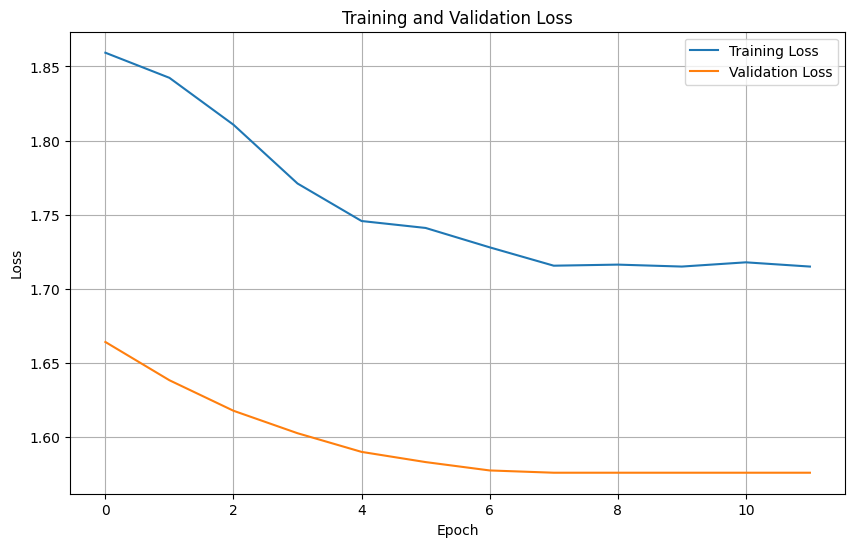

In [68]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [69]:
# Load the best model for evaluation
model.load_state_dict(torch.load(best_model_path))

# Evaluate on test set
test_loss = evaluate(model, test_loader, device)
print(f"Test Loss: {test_loss:.4f}")

Evaluating: 100%|██████████| 16/16 [00:04<00:00,  3.96it/s]

Test Loss: 1.5915


In [47]:
pip install rouge-score


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=262fd79dad9b4b569ab9f7846d606c8239a0df6af17544082e942a995a9111ab
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score
Note: you may need to restart the kernel to use updated packages.


In [70]:
from rouge_score import rouge_scorer
import numpy as np

# Set up the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Get some examples from test set
sample_indices = np.random.choice(len(test_df), 5, replace=False)
samples = test_df.iloc[sample_indices]

for i, row in samples.iterrows():
    commentary = row['Commentary']
    actual_report = row['MatchReport']
    
    print(f"Example {i}:")
    print(f"Commentary (truncated): {commentary[:200]}...")
    
    # Generate prediction
    generated_report = generate_match_report(model, tokenizer, commentary, device)
    print(f"Generated Report: {generated_report}")
    print(f"Actual Report: {actual_report}")
    
    # Calculate ROUGE scores
    scores = scorer.score(actual_report, generated_report)
    
    rouge1 = scores['rouge1'].fmeasure
    rouge2 = scores['rouge2'].fmeasure
    rougeL = scores['rougeL'].fmeasure
    
    print(f"ROUGE-1: {rouge1:.4f}, ROUGE-2: {rouge2:.4f}, ROUGE-L: {rougeL:.4f}")
    print("-" * 80)


Example 535:
Commentary (truncated): Corner, Everton. Conceded by Ezri Konsa. Fourth official has announced 7 minutes of added time. Offside, Everton. Dwight McNeil is caught offside. Foul by Youri Tielemans (Aston Villa). Dominic Calver...
Generated Report: The first half ended goalless, with Aston Villa leading Everton 1-0 at halftime. Morgan Rogers' shot was saved, while Jacob Ramsey's shot was too high following a corner. The second half ended with Aston Villa leading 1-0.
Actual Report: Aston Villa started the second half trailing 2-1. Morgan Rogers had a shot saved, while Jacob Ramsey's attempt was blocked. Calvert-Lewin earned a free kick for Everton, while McGinn was caught offside. Villa then scored from a corner. Ashley Young suffered an injury.
ROUGE-1: 0.4651, ROUGE-2: 0.2143, ROUGE-L: 0.3256
--------------------------------------------------------------------------------
Example 806:
Commentary (truncated): Offside, Bournemouth. Dango Ouattara is caught offside. Offside, B

Calculating ROUGE scores: 100%|██████████| 128/128 [02:38<00:00,  1.24s/it]

Average ROUGE Score: 0.2990


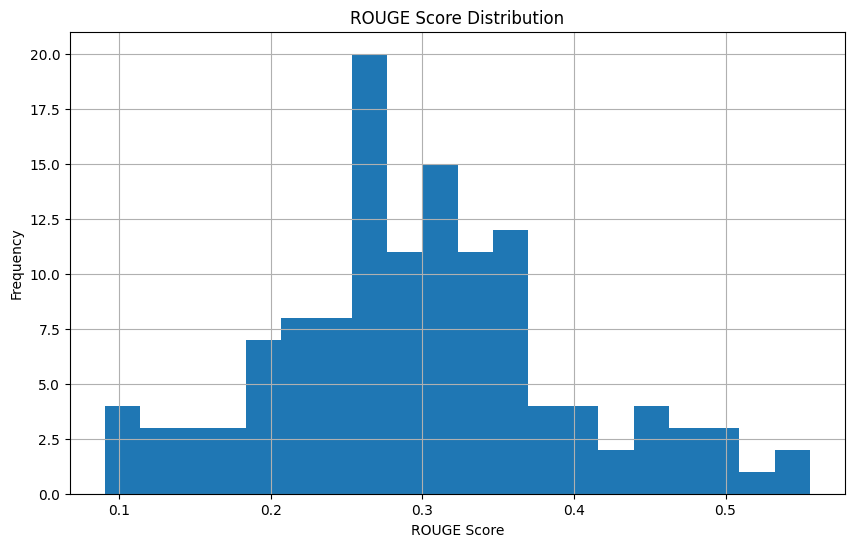

In [71]:
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
from tqdm import tqdm

# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Function to calculate ROUGE score
def calculate_rouge(reference, hypothesis):
    score = scorer.score(reference, hypothesis)
    return score['rougeL'].fmeasure  # You can change this to 'rouge1' or 'rouge2' if needed

# Calculate ROUGE for entire test set
total_rouge = 0
all_rouge_scores = []

for i, row in tqdm(test_df.iterrows(), desc="Calculating ROUGE scores", total=len(test_df)):
    commentary = row['Commentary']
    actual_report = row['MatchReport']
    
    generated_report = generate_match_report(model, tokenizer, commentary, device)
    rouge = calculate_rouge(actual_report, generated_report)
    
    total_rouge += rouge
    all_rouge_scores.append(rouge)

average_rouge = total_rouge / len(test_df)
print(f"Average ROUGE Score: {average_rouge:.4f}")

# Plot ROUGE score distribution
plt.figure(figsize=(10, 6))
plt.hist(all_rouge_scores, bins=20)
plt.title('ROUGE Score Distribution')
plt.xlabel('ROUGE Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [73]:
import os
import torch

# Create the models folder if it doesn't exist
os.makedirs('models1', exist_ok=True)

# Save just the model weights and tokenizer vocabulary
torch.save(model.state_dict(), 'models1/match_report_model12.pt')

# Save tokenizer information (vocabulary and special tokens)
tokenizer_info = {
    'vocab': tokenizer.get_vocab(),
    'special_tokens': tokenizer.special_tokens_map
}
torch.save(tokenizer_info, 'models1/match_report_tokenizer.pt')

print("Model and tokenizer saved in the 'models' folder")


Model and tokenizer saved in the 'models' folder


In [25]:
# First, mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set the target directory in Google Drive where you want to save your files
# Create this directory manually in your Drive first
drive_path = '/content/drive/'  # Change this to your preferred directory

# Create the directory if it doesn't exist
import os
if not os.path.exists(drive_path):
    os.makedirs(drive_path)
    print(f"Created directory: {drive_path}")

# Copy your model files to Google Drive
import shutil

# For individual files
source_files = [
    'match_report_model.pt',
    'match_report_tokenizer.pt'
    # Add other specific files you want to copy
]

for file in source_files:
    if os.path.exists(file):
        shutil.copy(file, os.path.join(drive_path, file))
        print(f"Copied {file} to Drive")
    else:
        print(f"Warning: {file} not found")


NotImplementedError: Mounting drive is unsupported in this environment. Use PyDrive instead. See examples at https://colab.research.google.com/notebooks/io.ipynb#scrollTo=7taylj9wpsA2.

In [74]:
import shutil

shutil.make_archive('zipped_file1_name', 'zip', '/kaggle/working/models1')


'/kaggle/working/zipped_file1_name.zip'

In [75]:
from IPython.display import FileLink
FileLink(r'zipped_file1_name.zip')

/kaggle/working/zipped_file1_name.zip